Heart Failure Prediction

"Cardiovascular diseases (CVDs) are the number 1 cause of death globally" (LARXEL, kaggle) and it is truly concerning how it is taking over many lives, like family members losing their love ones due to it, people needing to live their lives in hospitals, and so on. We hope to be able to use this opportunity to discover different factors that could lead to heart failure and building a model to predict those who are most in need and hopefully get them the medical attention they require.

Our main focus of this project is to determine which factors have a significant contribution towards heart failure. The data we obtained consists of factors such as diabetes, high blood pressure, age, sex, whether someone smokes, and so on. Our goal is to use these factors as predictors to predict if someone should receive medical attention immediately or not. If predictions indicates death, it would suggest doctors to focus on this case immediately to prevent death, and if it indicates they are going to survive, then we would do precautions to prevent them from falling into the categories that might lead them to death. 

This dataset we gathered is from Kaggle, which was released by user LARXEL in 2020.

In [17]:
#load necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [16]:
#Use read_csv to load the dataset into R. (We downloaded the dataset manually from kaggle
#and uploaded it to R)
data <- read_csv("data/heart_failure_clinical_records_dataset.csv.xls")
data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


In [3]:
#Find number of rows and columns of dataset.
data_nrow <- nrow(data)
data_nrow

data_ncol <- ncol(data)
data_ncol

[1] 299

[1] 13

This dataset consists of 299 rows and 13 columns. The DEATH_EVENT variable has values 0 (survived) and 1 (died) and as stated above, we will use this to gain some understanding of a person’s medical condition to further prevent the death of others. In other words, we will use data of patients who survived or died to determine if someone needs to seek medical attention immediately. We will use some of these columns to explore our data. In the event where the data is not sufficient, we will gather more data from other sources such as ourworldindata.org.

In [13]:
#wrangling the data by selecting the predictors we would work with and 
#converting the response variable DEATH_EVENT to the factor datatype and renaming it to "survived"
#converting the predicting variables that has results 0 or 1 to the logical datatype so it shows as TRUE or FALSE

data_wrangled <- data |> 
            select(age, diabetes, ejection_fraction, high_blood_pressure, smoking, DEATH_EVENT) |>
            mutate(DEATH_EVENT = as_factor(DEATH_EVENT)) |>
            mutate(DEATH_EVENT = fct_recode(DEATH_EVENT, "Yes" = "0", "No" = "1")) |>
            rename("survived" = "DEATH_EVENT") |>
            mutate(diabetes = as.logical(diabetes)) |>
            mutate(high_blood_pressure = as.logical(high_blood_pressure)) |>
            mutate(smoking = as.logical(smoking))    

data_wrangled

age,diabetes,ejection_fraction,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<fct>
75,FALSE,20,TRUE,FALSE,No
55,FALSE,38,FALSE,FALSE,No
65,FALSE,20,FALSE,TRUE,No
⋮,⋮,⋮,⋮,⋮,⋮
45,TRUE,60,FALSE,FALSE,Yes
45,FALSE,38,FALSE,TRUE,Yes
50,FALSE,45,FALSE,TRUE,Yes


The full dataset consisted of 12 variables that we could work with, some which are categorical, like diabetes (either yes or no) and some which are doubles, like age. We are mainly going to focus on these 5 predictors (age, diabetes, ejection fraction, high blood pressure, and smoking) for now to see if they correlate to heart failure. 

In [5]:
#set the random seed in R
set.seed(1)

#split the data into training and testing set
heart_split <- initial_split(data_wrangled, prop = 0.75, strata = survived)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

age,diabetes,ejection_fraction,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<fct>
75,FALSE,20,TRUE,FALSE,No
55,FALSE,38,FALSE,FALSE,No
90,FALSE,40,TRUE,TRUE,No
⋮,⋮,⋮,⋮,⋮,⋮
62,TRUE,38,TRUE,TRUE,Yes
55,FALSE,38,FALSE,FALSE,Yes
45,TRUE,60,FALSE,FALSE,Yes


age,diabetes,ejection_fraction,high_blood_pressure,smoking,survived
<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<fct>
65,FALSE,20,FALSE,TRUE,No
50,FALSE,20,FALSE,FALSE,No
65,TRUE,20,FALSE,FALSE,No
⋮,⋮,⋮,⋮,⋮,⋮
60,FALSE,35,FALSE,FALSE,Yes
45,FALSE,38,FALSE,TRUE,Yes
50,FALSE,45,FALSE,TRUE,Yes


In [6]:
#the number of observations in the training set
train_nrow <- nrow(heart_train)
any_missing_data <- sum(is.na(heart_train))
summarize(heart_train, train_nrow, any_missing_data)

train_nrow,any_missing_data
<int>,<int>
224,0


Our training data consists of 224 rows and we have no missing data.

In [7]:
#summarize values for subgroups "survived" or "died" within the training data set
survive_or_death_summarize <- heart_train |> 
                           group_by(survived) |>
                           summarise(count = n())
survive_or_death_summarize

survived,count
<fct>,<int>
Yes,152
No,72


Out of the 224 rows of training data, 152 are people who survived and 72 are people who died.

In [8]:
#summarize variables that are double
summarize_age <- heart_train |>
                 summarize(variable = "age", 
                           min = min(age), 
                           max = max(age), 
                           mean = mean(age))
summarize_ejection_fraction <- heart_train |>
                               summarize(variable = "ejection_fraction", 
                                         min = min(ejection_fraction), 
                                         max = max(ejection_fraction),
                                         mean = mean(ejection_fraction))

train_summarized <- rbind(summarize_age, summarize_ejection_fraction)
train_summarized

variable,min,max,mean
<chr>,<dbl>,<dbl>,<dbl>
age,40,95,60.89881
ejection_fraction,14,80,37.75893


We summarized variables that are double to see the min, max, and mean. (Did not do this for variables that are logical since it is just a TRUE or FALSE observation.)

Now, using our training data, we will see if any of our predictors have a relationship with each other (2 predictors) that indicates heart failure or if any of the predictors independently indicates a heart failure (1 predictor). Here are some plots:

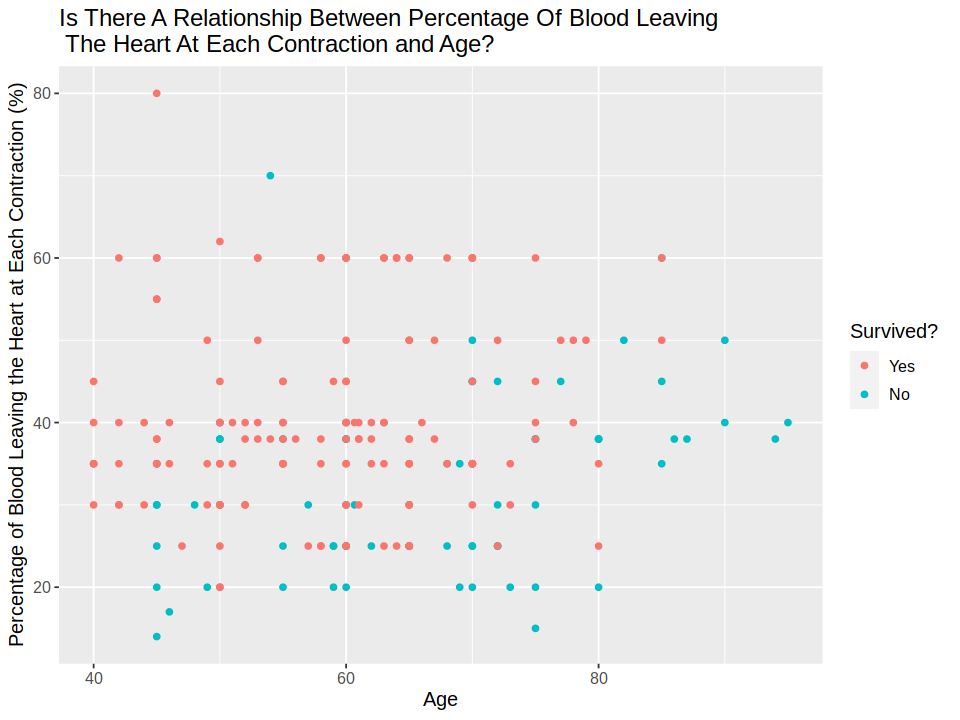

In [9]:
#set our graph to a proper size for visualization
options(repr.plot.width = 8, repr.plot.height = 6)

#visualize the data with a scatter plot
train_graph_point <- heart_train |>
            ggplot(aes(x = age, y = ejection_fraction, color = survived)) +
            geom_point() + 
            labs(x = "Age", 
                 y = "Percentage of Blood Leaving the Heart at Each Contraction (%)",
                 color = "Survived?") +
            theme(text = element_text(size = 12)) +
            ggtitle("Is There A Relationship Between Percentage Of Blood Leaving \n The Heart At Each Contraction and Age?") 
train_graph_point

We hypothesized age and the percentage of blood leaving the heart at each contraction to have a relationship so we plotted this graph. The relationship is pretty weak but we could see that those who survived are generally younger and that the percentage of blood leaving the heart at each contraction is relatively average or above average. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


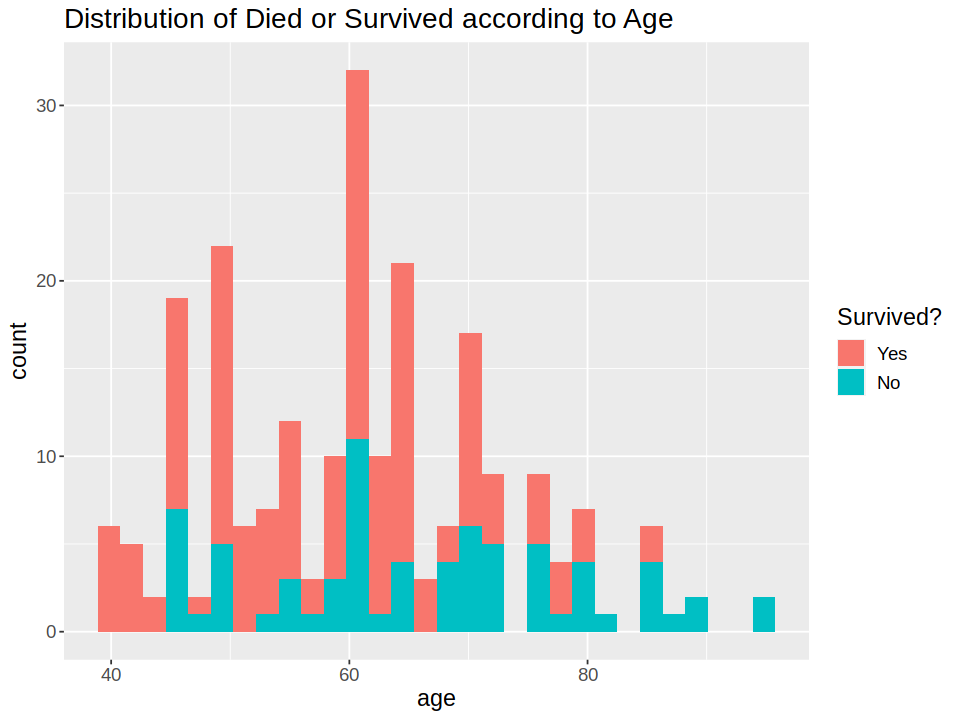

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
train_graph <- heart_train |>
            ggplot(aes(x = age, fill = survived)) +
            geom_histogram() + 
            labs(x = "age",
                 fill = "Survived?") +
            theme(text = element_text(size = 14)) +
            ggtitle("Distribution of Died or Survived according to Age")
train_graph

This histogram plot does not show a clear distribution, but we should be aware that at older ages, those who died outnumbers those who survived (considering that the data for people who died is almost half of those that survived, recall that: survived total ~ 152; Died total ~ 72). Whereas at younger ages (from around ages 40-65), those who survive would outnumber those who die. From this, we can tell that age could be a factor, but there are definitely other factors that influence heart failure too, since there is not a clear distribution.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


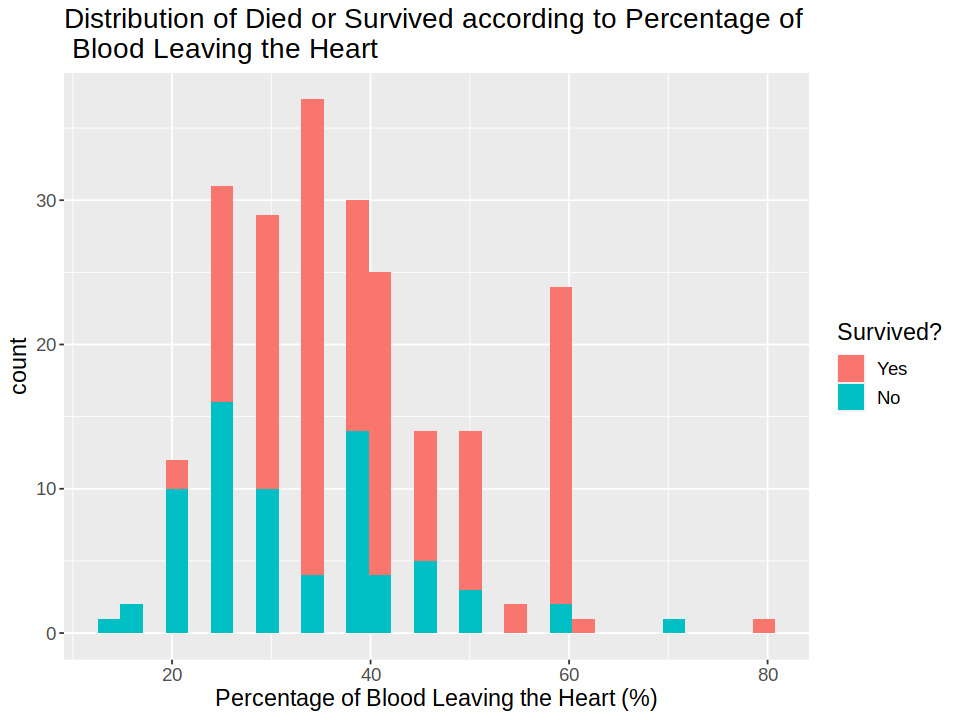

In [18]:
options(repr.plot.width = 8, repr.plot.height = 6)
train_graph_2 <- heart_train |>
            ggplot(aes(x = ejection_fraction, fill = survived)) +
            geom_histogram() + 
            labs(x = "Percentage of Blood Leaving the Heart (%)",
                 fill = "Survived?") +
            theme(text = element_text(size = 14)) +
            ggtitle("Distribution of Died or Survived according to Percentage of \n Blood Leaving the Heart")
train_graph_2

This histogram plot does not show a clear distribution too but overall we could see that lower percentage of blood leaving the heart causes increased death (keep in mind about the 152 survived and 72 died distribution mentioned above, if we scale it right, people who died would dominate towards the left side, while those that survive would dominate the middle to right side (around the 32-62 range)). 

Since this is just the exploratory phase, we chose to mainly focus on these two predictor variables to get ourselves on the right track and we will work our way towards the remaining three predictor variables in the next few weeks. 

We will conduct our data analysis with all 5 of our predictor variables, find the most suitable k-values for them, and see which one yields the best accuracy. We will then use the one with the highest accuracy to predict which class they belong to and determine if they would need immediate medical attention. We would do so by making visualizations, like using a scatter plot graph where points are connected by lines to see the which k-value gives us the most accuracy (essentially, the whole knn-classification process).

We expect (to the best of our abilities) to produce a model that would be viable to predict if someone's data indicate they are going to die or not and determine if they would need immediate medical attention or not. 

The model we will build with the most optimal K could help healthcare providers determine patients who are more at risk of heart failure. They can intervene with preventive measures, personalized treatment plans, and timely check-ups and this can hopefully lead to improved patient outcomes.

Of course, our model would be very basic which could definitely be improved by more professional individuals with more data, more advanced data science knowledge, etc. We are doing a very small part here, questions like "what other factors could determine if someone is going to have a heart failure or not" could pop up. Note that we only have 13 variables here, from our common knowledge, we could already list out other different variables that potentially relate to heart failure, like the amount someone exercises, their diet, how much sleep they get per day, literally countless other variables that could lead to heart failure. "How would their relationship be?", "Would we get a higher accuracy when we are encompassing more variables?", tons of questions like these could come up as we delve deeper into this data analysis.